In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
data_path = '/content/drive/MyDrive/data2.txt'
data = pd.read_csv(data_path, header=None, names = ["x1","x2","y"])
data.head()

,x1,x2,y
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


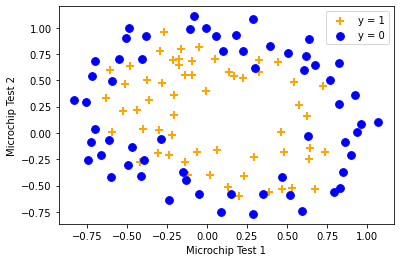

In [16]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data['y'] == 0
    pos = data['y'] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos]['x1'], data[pos]['x2'], marker='+', c='orange', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg]['x1'], data[neg]['x2'], c='blue', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);


plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

In [17]:
n = data.shape[1]-1
x = data[data.columns[0:n]]

y = data[data.columns[n:n+1]]
# convert to np.array
X = x.values
y = y.values

In [18]:
##all possible combination of x and y for given degrees
def mapFeature( x1col, x2col):
    degrees = 8
    out = np.ones( (x1col.shape[0], 1) )
    # print(out.shape)

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out = np.hstack(( out, term ))
    return out

In [19]:
XX = mapFeature(X[:,0],X[:,1])
print(X.shape, XX.shape)

(118, 2) (118, 45)


In [20]:
from scipy.special import expit #Vectorized sigmoid function

#Hypothesis function and cost function for logistic regression
def h(mytheta,myX): #Logistic hypothesis function
    return expit(np.dot(myX,mytheta))

In [21]:
#Cost function, default lambda (regularization) 0
def computeCost(mytheta,myX,myy,mylambda = 0.): 

    m = myy.size # number of training examples

    term1 = np.dot(-np.array(myy).T,np.log(h(mytheta,myX)))
    term2 = np.dot((1-np.array(myy)).T,np.log(1-h(mytheta,myX)))
    regterm = (mylambda/2) * np.sum(np.dot(mytheta[1:].T,mytheta[1:])) #Skip theta0
    return float( (1./m) * ( np.sum(term1 - term2) + regterm ) )

In [22]:
def sigmoid(z):
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))
    return g

In [25]:
# from scipy import optimize
import copy
import math
initial_theta = np.zeros(XX.shape[1])
print(initial_theta.shape)

# used optimize.minimize function

def optimizeRegularizedTheta(mytheta, myX, myy, alpha, num_iters, mylambda=0.):
  m = myX.shape[0]
  d_list = []
  w = copy.deepcopy(mytheta)

  for i in range(num_iters):
  
    val = compute_gradient_logistic(myX, myy, w)  
    w = w*(1-alpha*(mylambda/m)) - alpha * val              
  
    if i<100000:     
        d_list.append(computeCost(w, myX, myy, mylambda))

    if i% math.ceil(num_iters / 10) == 0:
        print(f"Iteration {i:4d}: Cost {d_list[-1]}   ")
  return w, min(d_list)
    
theta, mincost = optimizeRegularizedTheta(initial_theta,XX,y, 0.1, 100)
print(theta.shape)
print(mincost)

(45,)
Iteration    0: Cost 0.6914929608470252   
Iteration   10: Cost 0.6775203445186196   
Iteration   20: Cost 0.6666640333480375   
Iteration   30: Cost 0.6576047050899368   
Iteration   40: Cost 0.6496830141298244   
Iteration   50: Cost 0.6425530352786331   
Iteration   60: Cost 0.6360192327933389   
Iteration   70: Cost 0.6299609717349424   
Iteration   80: Cost 0.6242971432254854   
Iteration   90: Cost 0.6189690990335762   
(45,)
0.6144237302084337


In [26]:
def compute_gradient_logistic(X, y, w):
  m,n = X.shape
  val = np.zeros((n,))

  for i in range(m):
    f_wb_i = sigmoid(np.dot(X[i], w))               
    err_i  = f_wb_i  - y[i]                    
    for j in range(n):
      val[j] = val[j] + err_i * X[i,j]        
  val = val/m                                  
      
  return val

In [27]:
def plotBoundary(mytheta, myX, myy, mylambda=0.):
    """
    Function to plot the decision boundary for arbitrary theta, X, y, lambda value
    Inside of this function is feature mapping, and the minimization routine.
    It works by making a grid of x1 ("xvals") and x2 ("yvals") points,
    And for each, computing whether the hypothesis classifies that point as
    True or False. Then, a contour is drawn with a built-in pyplot function.
    """
    alpha = .1
    iters = 1000
    
    theta, mincost = optimizeRegularizedTheta(mytheta,myX,myy,alpha, iters,mylambda)
    print(theta, '\n\nCost : ', mincost, '\n \n ')
    xvals = np.linspace(-1,1.5,50)
    yvals = np.linspace(-1,1.5,50)
    zvals = np.zeros((len(xvals),len(yvals)))
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            myfeaturesij = mapFeature(np.array([xvals[i]]),np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta,myfeaturesij.T)
            # print(type(zvals), zvals.shape)
    zvals = zvals.transpose()

    u, v = np.meshgrid( xvals, yvals )
    mycontour = plt.contour( xvals, yvals, zvals, [0])
    #Kind of a hacky way to display a text on top of the decision boundary
    myfmt = { 0:'Lambda = %f'%mylambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
    plt.title("Decision Boundary")

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plotBoundary(initial_theta,XX,y,0.)

plt.subplot(222)
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plotBoundary(initial_theta,XX,y,1.)

plt.subplot(223)
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plotBoundary(initial_theta,XX,y,10.)

plt.subplot(224)
plotData(data, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')
plotBoundary(initial_theta,XX,y,50.)

Iteration    0: Cost 0.6914929608470252   
Iteration  100: Cost 0.6139320486985876   
Iteration  200: Cost 0.5740852663079716   
Iteration  300: Cost 0.5452905416509011   
Iteration  400: Cost 0.5227507692531224   
Iteration  500: Cost 0.5044471319207976   
Iteration  600: Cost 0.48922859549703274   
Iteration  700: Cost 0.47634735205041284   
Iteration  800: Cost 0.46528638629824526   
Iteration  900: Cost 0.4556743499864037   
[ 1.28297461  0.72831649  1.36491833 -2.09132828 -0.93686576 -1.22761792
  0.19072431 -0.40344533 -0.39975398 -0.07837714 -1.55941347 -0.08875276
 -0.65848462 -0.28753193 -1.14940499 -0.21494578 -0.24097696 -0.07583021
 -0.2924084  -0.32030148 -0.43779177 -1.12095521  0.00299405 -0.32258954
 -0.00381255 -0.34959902 -0.1537389  -0.94291699 -0.36048    -0.12634256
 -0.05921805 -0.12615194 -0.04922914 -0.18950797 -0.21182754 -0.53660547
 -0.83445846  0.01550611 -0.1742484   0.00366218 -0.14100112  0.00290321
 -0.21100339 -0.09953179 -0.79398814] 

Cost :  0.447316